## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import f
from sklearn.preprocessing import StandardScaler
%matplotlib inline

## Data

In [2]:
train_normal = pd.read_csv('./data/normal_training.csv')

In [3]:
test_faulty = pd.read_csv('./data/faulty_testing.csv')

## The KPCA Class

In [4]:
class KPCA():
    
    def __init__(self, n_comp=16):
        ## initialize with number of component in kpca process
        self.n_comp = n_comp
        
        
    def train(self, dataTrain, conf_T2=0.95):
        ## initialize important parameter
        self.nSamples = dataTrain.shape[0]
        self.conf_T2 = conf_T2
        
        ## Standardize process
        std_scl = StandardScaler().fit(dataTrain)
        dtrn_scl = std_scl.transform(dataTrain)
        self.dtrn_scl = pd.DataFrame(dtrn_scl)
        
        ## centraling kernel
        A = self.dtrn_scl
        K = A@A.T
        K = np.round(K, 4)
        self.K = pd.DataFrame(K)
        
        ## make matrix 1 square with the number of sample
        s = (self.nSamples, self.nSamples)
        unit = np.ones(s)/self.nSamples
        unit = np.round(unit, 4)
        self.unit = pd.DataFrame(unit)
        
        ## kernel centering
        K_c = self.K-unit@self.K-self.K@unit+unit@self.K@unit
        self.K_c = np.round(K_c, 4)
        
        ## Compute Eigenvalues and Eigenvector
        u, s, vh = np.linalg.svd(self.K_c/self.nSamples)
        
        # LAMBDA
        lambda_ = s
        lambd = lambda_
        
        # COEFFICIENT
        cf = np.sqrt(self.nSamples*lambd)
        coefficient = np.divide(u, cf.T)
        
        # eigvls = eigvls.real
        eigvls = lambd
        eigvls = np.round(eigvls, 4)
        self.eigvls = pd.DataFrame(eigvls)
        
        # eigvct = eigvct.real
        eigvct = coefficient
        self.eigvct = pd.DataFrame(eigvct)
        
        ## get the score matrix
        score_train = self.K_c@self.eigvct.iloc[:,:self.n_comp]
        score_train = np.round(score_train, 4)
        score_train = pd.DataFrame(score_train)
        
        ### T2 Process ###
        a = self.eigvls.iloc[:self.n_comp,:]
        z = a.values.tolist()
        extract_egv=[]
        for i in range(len(z)):
            extract_egv.append(z[i][0])
        ## extracted eigen value
        c = np.diag(extract_egv)
        ## eigen value with linear diagonal value
        invegvldiag = c
        self.invegvldiag = pd.DataFrame(invegvldiag)
        
        ### T2 Score ###
        T2_train = score_train@self.invegvldiag@score_train.T
        self.T2_tfinal = np.diag(T2_train)
        
        ### Tlim ###
        F = f.ppf(self.conf_T2, self.n_comp, self.nSamples-self.n_comp)
        self.T2_trlim = ((self.n_comp*(self.nSamples**2-1))/(self.nSamples*(self.nSamples-self.n_comp)))*F
        
    def test(self, dataTest):
        ## Standardize process
        std_scl = StandardScaler().fit(dataTest)
        dtst_scl = std_scl.transform(dataTest)
        self.dtst_scl = pd.DataFrame(dtst_scl)
        
        ## centralize the kernel
        Kt = self.dtst_scl@self.dtrn_scl.T
        Kt = np.round(Kt, 4)
        self.Kt = pd.DataFrame(Kt)
        
        ## make matrix 1 square with the number of sample
        st = (len(self.dtst_scl),len(self.dtrn_scl)) # 2000 or 960
        unit_t = np.ones(st)/len(self.dtrn_scl)
        unit_t = np.round(unit_t, 4)
        unit_t = pd.DataFrame(unit_t)
        
        ## kernel centering
        Kt_c = self.Kt-unit_t@self.K-self.Kt@self.unit+unit_t@self.K@self.unit
        Kt_c = np.round(Kt_c, 4)
        
        ## get the score matrix
        score_test = Kt_c@self.eigvct.iloc[:,:self.n_comp]
        score_test = np.round(score_test, 4)
        
        ### T2 Score ###
        T2_test = score_test@self.invegvldiag@score_test.T
        T2_test_final = np.diag(T2_test)
        T2_test = np.round(T2_test, 4)
        self.T2_test_final = np.diag(T2_test)
        
    def printDescribe(self):
        print("number component : ",self.n_comp)
        print("number of samples : ",self.nSamples)
        print("T2 Limit : ",self.T2_trlim)
        print("")
        print("")
        
    def plotTestResult(self):
        plt.figure(figsize=(6,4))
        plt.semilogy(self.T2_test_final,'.')
        plt.axhline(self.T2_trlim, ls='--',c='r')
        plt.axvline(160, c='k')
        plt.title('$T^2$ statistic')
        plt.show()
        ## print the T2 score
        print(f'T2: {(self.T2_test_final>self.T2_trlim).sum()/self.T2_test_final.shape[0]}')
        
    def plotTrainResult(self):
        plt.semilogy(self.T2_tfinal,'.')
        plt.axhline(self.T2_trlim, ls='--',c='r')
        plt.title('$T^2$ statistic')
        plt.show()
        ## print the T2 score
        print(f'T2: {(self.T2_tfinal>self.T2_trlim).sum()/self.T2_tfinal.shape[0]}')

## Train process

In [5]:
df_train = train_normal[(train_normal.simulationRun>=1)].iloc[:500,3:]

In [6]:
kpca = KPCA(n_comp=16)

In [7]:
kpca.train(df_train)

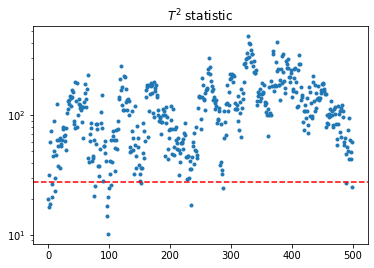

T2: 0.962


In [8]:
kpca.plotTrainResult()

In [9]:
IDV = 1
df_test = test_faulty[(test_faulty.faultNumber==IDV) & 
                               (test_faulty.simulationRun==1)].iloc[:,3:]

In [10]:
kpca.test(df_test)

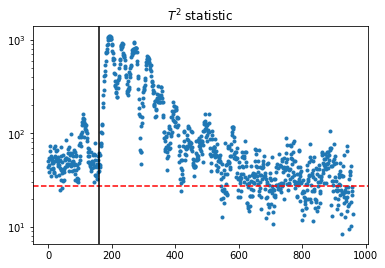

T2: 0.853125


In [11]:
kpca.plotTestResult()

In [12]:
IDV = 2
df_test = test_faulty[(test_faulty.faultNumber==IDV) & 
                               (test_faulty.simulationRun==1)].iloc[:,3:]

In [13]:
kpca.test(df_test)

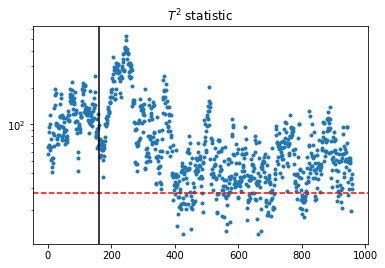

T2: 0.8947916666666667


In [14]:
kpca.plotTestResult()

In [15]:
IDV = 3
df_test = test_faulty[(test_faulty.faultNumber==IDV) & 
                               (test_faulty.simulationRun==1)].iloc[:,3:]

In [16]:
kpca.test(df_test)

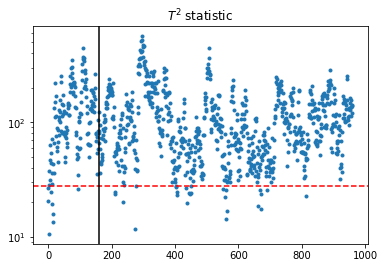

T2: 0.9677083333333333


In [17]:
kpca.plotTestResult()

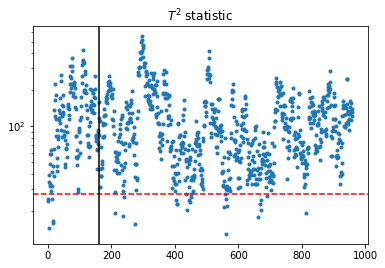

T2: 0.96875


In [18]:
IDV = 4
df_test = test_faulty[(test_faulty.faultNumber==IDV) & 
                               (test_faulty.simulationRun==1)].iloc[:,3:]

kpca.test(df_test)
kpca.plotTestResult()

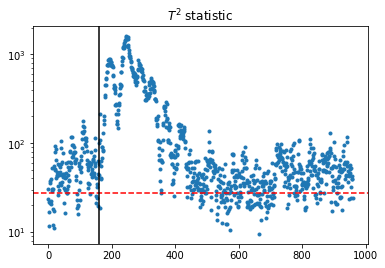

T2: 0.8479166666666667


In [19]:
IDV = 5
df_test = test_faulty[(test_faulty.faultNumber==IDV) & 
                               (test_faulty.simulationRun==1)].iloc[:,3:]

kpca.test(df_test)
kpca.plotTestResult()

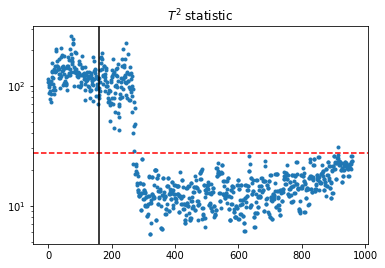

T2: 0.2864583333333333


In [20]:
IDV = 6
df_test = test_faulty[(test_faulty.faultNumber==IDV) & 
                               (test_faulty.simulationRun==1)].iloc[:,3:]

kpca.test(df_test)
kpca.plotTestResult()

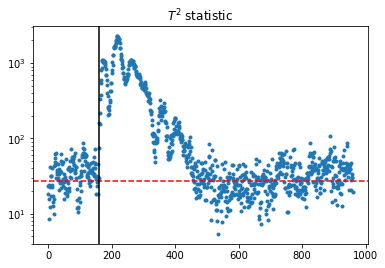

T2: 0.6927083333333334


In [21]:
IDV = 7
df_test = test_faulty[(test_faulty.faultNumber==IDV) & 
                               (test_faulty.simulationRun==1)].iloc[:,3:]

kpca.test(df_test)
kpca.plotTestResult()

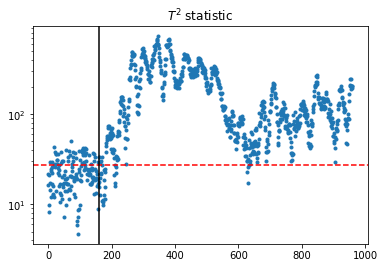

T2: 0.859375


In [22]:
IDV = 8
df_test = test_faulty[(test_faulty.faultNumber==IDV) & 
                               (test_faulty.simulationRun==1)].iloc[:,3:]

kpca.test(df_test)
kpca.plotTestResult()

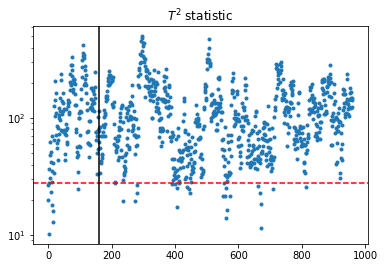

T2: 0.9677083333333333


In [23]:
IDV = 9
df_test = test_faulty[(test_faulty.faultNumber==IDV) & 
                               (test_faulty.simulationRun==1)].iloc[:,3:]

kpca.test(df_test)
kpca.plotTestResult()

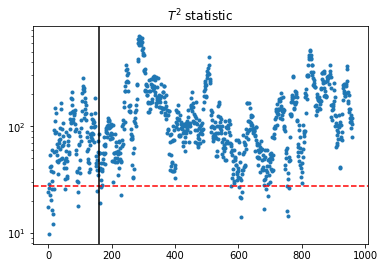

T2: 0.96875


In [24]:
IDV = 10
df_test = test_faulty[(test_faulty.faultNumber==IDV) & 
                               (test_faulty.simulationRun==1)].iloc[:,3:]

kpca.test(df_test)
kpca.plotTestResult()

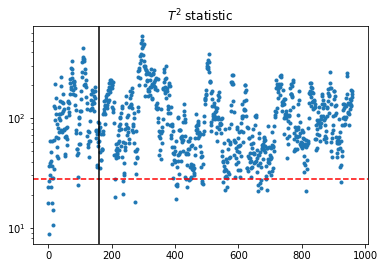

T2: 0.9645833333333333


In [25]:
IDV = 11
df_test = test_faulty[(test_faulty.faultNumber==IDV) & 
                               (test_faulty.simulationRun==1)].iloc[:,3:]

kpca.test(df_test)
kpca.plotTestResult()

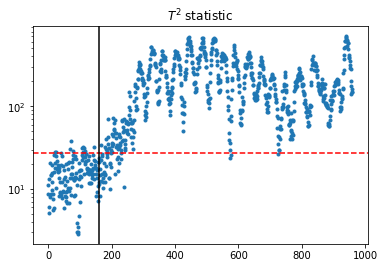

T2: 0.803125


In [26]:
IDV = 12
df_test = test_faulty[(test_faulty.faultNumber==IDV) & 
                               (test_faulty.simulationRun==1)].iloc[:,3:]

kpca.test(df_test)
kpca.plotTestResult()

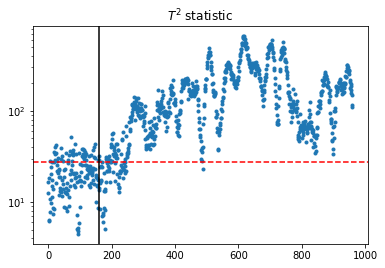

T2: 0.8239583333333333


In [27]:
IDV = 13
df_test = test_faulty[(test_faulty.faultNumber==IDV) & 
                               (test_faulty.simulationRun==1)].iloc[:,3:]

kpca.test(df_test)
kpca.plotTestResult()

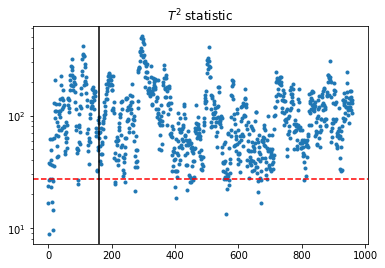

T2: 0.9635416666666666


In [28]:
IDV = 14
df_test = test_faulty[(test_faulty.faultNumber==IDV) & 
                               (test_faulty.simulationRun==1)].iloc[:,3:]

kpca.test(df_test)
kpca.plotTestResult()

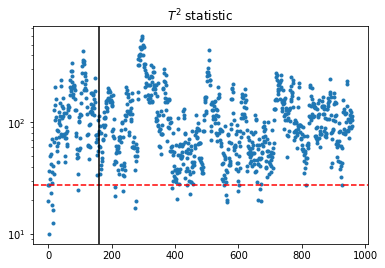

T2: 0.9697916666666667


In [29]:
IDV = 15
df_test = test_faulty[(test_faulty.faultNumber==IDV) & 
                               (test_faulty.simulationRun==1)].iloc[:,3:]

kpca.test(df_test)
kpca.plotTestResult()

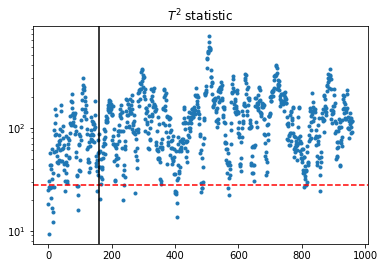

T2: 0.965625


In [30]:
IDV = 16
df_test = test_faulty[(test_faulty.faultNumber==IDV) & 
                               (test_faulty.simulationRun==1)].iloc[:,3:]

kpca.test(df_test)
kpca.plotTestResult()

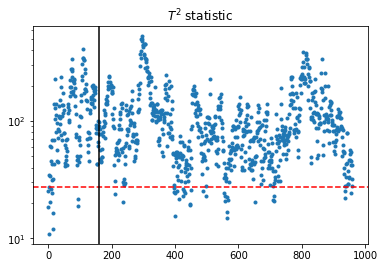

T2: 0.9572916666666667


In [31]:
IDV = 17
df_test = test_faulty[(test_faulty.faultNumber==IDV) & 
                               (test_faulty.simulationRun==1)].iloc[:,3:]

kpca.test(df_test)
kpca.plotTestResult()

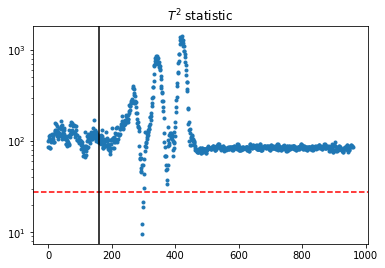

T2: 0.9958333333333333


In [32]:
IDV = 18
df_test = test_faulty[(test_faulty.faultNumber==IDV) & 
                               (test_faulty.simulationRun==1)].iloc[:,3:]

kpca.test(df_test)
kpca.plotTestResult()

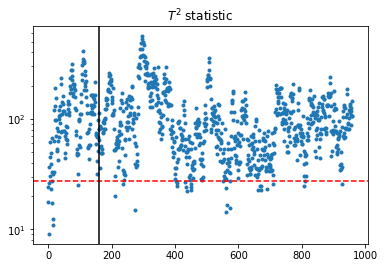

T2: 0.9635416666666666


In [33]:
IDV = 19
df_test = test_faulty[(test_faulty.faultNumber==IDV) & 
                               (test_faulty.simulationRun==1)].iloc[:,3:]

kpca.test(df_test)
kpca.plotTestResult()

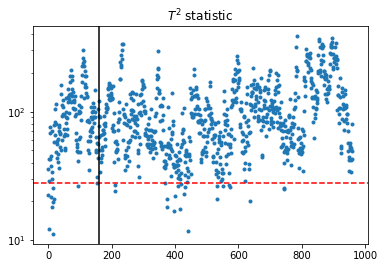

T2: 0.9697916666666667


In [34]:
IDV = 20
df_test = test_faulty[(test_faulty.faultNumber==IDV) & 
                               (test_faulty.simulationRun==1)].iloc[:,3:]

kpca.test(df_test)
kpca.plotTestResult()

## Adding time-delayed variable
or making dinamic kernel principal component

In [35]:
def apply_lag(df, lag = 1):
       
    from statsmodels.tsa.tsatools import lagmat
    array_lagged = lagmat(df, maxlag=lag,
                          trim="forward", original='in')[lag:,:]  
    new_columns = []
    for l in range(lag):
        new_columns.append(df.columns+'_lag'+str(l+1))
    columns_lagged = df.columns.append(new_columns)
    index_lagged = df.index[lag:]
    df_lagged = pd.DataFrame(array_lagged, index=index_lagged,
                             columns=columns_lagged)
       
    return df_lagged 

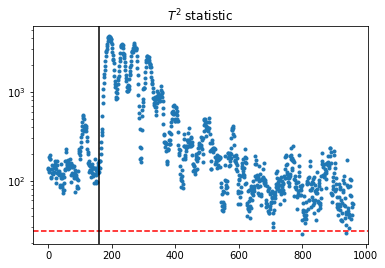

T2: 0.9979144942648592


In [36]:
IDV = 1
lag = 1
df_test = test_faulty[(test_faulty.faultNumber==IDV) & 
                               (test_faulty.simulationRun==1)].iloc[:,3:]
kpca.train(apply_lag(df_train, lag=lag))

kpca.test(apply_lag(df_test, lag=lag))
kpca.plotTestResult()

In [37]:
# if you want to know the lag do to our datas
# apply_lag(df_train, lag=1)

In [38]:
# we can compare it with the normal data 
# df_test

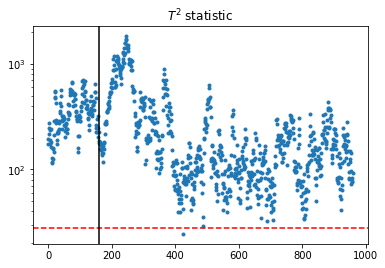

T2: 0.9989572471324296


In [39]:
IDV = 2
df_test = test_faulty[(test_faulty.faultNumber==IDV) & 
                               (test_faulty.simulationRun==1)].iloc[:,3:]
kpca.test(apply_lag(df_test, lag=lag))
kpca.plotTestResult()

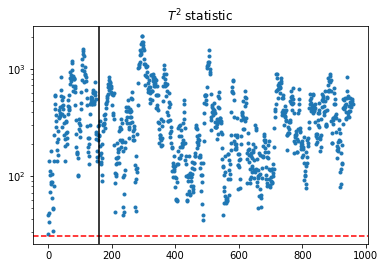

T2: 1.0


In [40]:
IDV = 3
df_test = test_faulty[(test_faulty.faultNumber==IDV) & 
                               (test_faulty.simulationRun==1)].iloc[:,3:]
kpca.test(apply_lag(df_test, lag=lag))
kpca.plotTestResult()

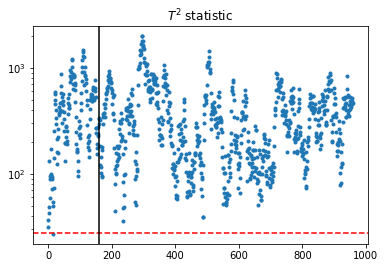

T2: 0.9989572471324296


In [41]:
IDV = 4
df_test = test_faulty[(test_faulty.faultNumber==IDV) & 
                               (test_faulty.simulationRun==1)].iloc[:,3:]
kpca.test(apply_lag(df_test, lag=lag))
kpca.plotTestResult()

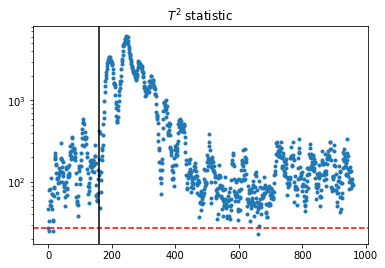

T2: 0.9958289885297185


In [42]:
IDV = 5
df_test = test_faulty[(test_faulty.faultNumber==IDV) & 
                               (test_faulty.simulationRun==1)].iloc[:,3:]
kpca.test(apply_lag(df_test, lag=lag))
kpca.plotTestResult()

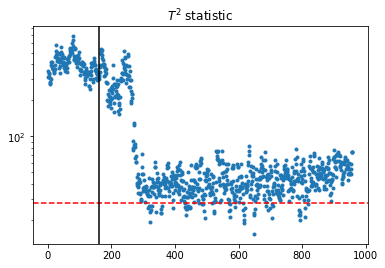

T2: 0.9416058394160584


In [43]:
IDV = 6
df_test = test_faulty[(test_faulty.faultNumber==IDV) & 
                               (test_faulty.simulationRun==1)].iloc[:,3:]
kpca.test(apply_lag(df_test, lag=lag))
kpca.plotTestResult()

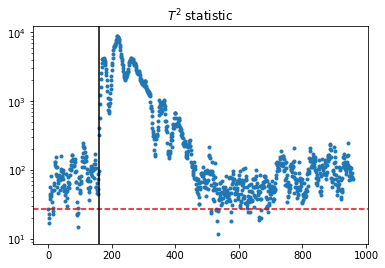

T2: 0.9718456725755996


In [44]:
IDV = 7
df_test = test_faulty[(test_faulty.faultNumber==IDV) & 
                               (test_faulty.simulationRun==1)].iloc[:,3:]
kpca.test(apply_lag(df_test, lag=lag))
kpca.plotTestResult()

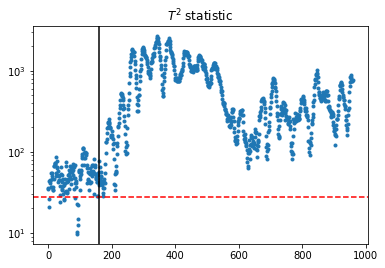

T2: 0.9874869655891554


In [45]:
IDV = 8
df_test = test_faulty[(test_faulty.faultNumber==IDV) & 
                               (test_faulty.simulationRun==1)].iloc[:,3:]
kpca.test(apply_lag(df_test, lag=lag))
kpca.plotTestResult()

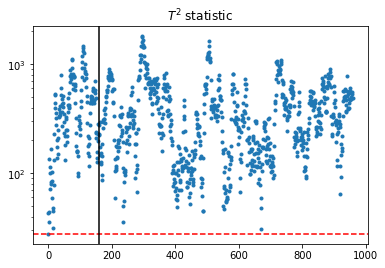

T2: 1.0


In [46]:
IDV = 9
df_test = test_faulty[(test_faulty.faultNumber==IDV) & 
                               (test_faulty.simulationRun==1)].iloc[:,3:]
kpca.test(apply_lag(df_test, lag=lag))
kpca.plotTestResult()

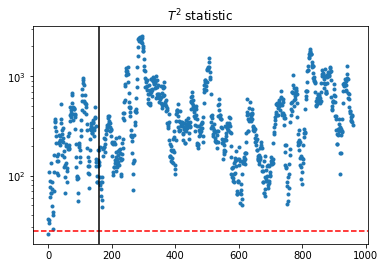

T2: 0.9989572471324296


In [47]:
IDV = 10
df_test = test_faulty[(test_faulty.faultNumber==IDV) & 
                               (test_faulty.simulationRun==1)].iloc[:,3:]
kpca.test(apply_lag(df_test, lag=lag))
kpca.plotTestResult()

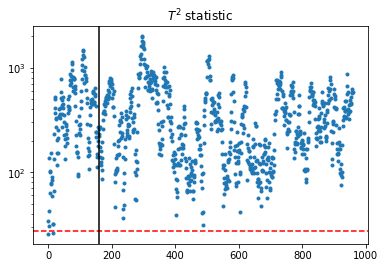

T2: 0.9979144942648592


In [48]:
IDV = 11
df_test = test_faulty[(test_faulty.faultNumber==IDV) & 
                               (test_faulty.simulationRun==1)].iloc[:,3:]
kpca.test(apply_lag(df_test, lag=lag))
kpca.plotTestResult()

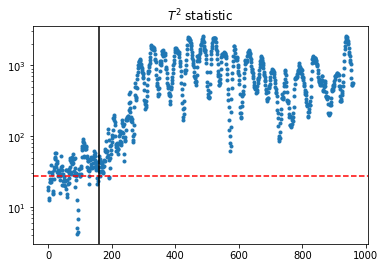

T2: 0.9499478623566214


In [49]:
IDV = 12
df_test = test_faulty[(test_faulty.faultNumber==IDV) & 
                               (test_faulty.simulationRun==1)].iloc[:,3:]
kpca.test(apply_lag(df_test, lag=lag))
kpca.plotTestResult()

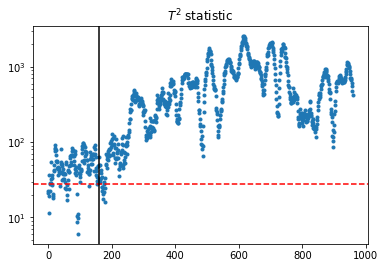

T2: 0.9666319082377477


In [50]:
IDV = 13
df_test = test_faulty[(test_faulty.faultNumber==IDV) & 
                               (test_faulty.simulationRun==1)].iloc[:,3:]
kpca.test(apply_lag(df_test, lag=lag))
kpca.plotTestResult()

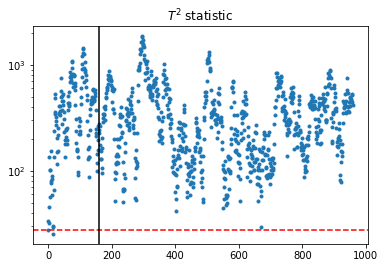

T2: 0.9979144942648592


In [51]:
IDV = 14
df_test = test_faulty[(test_faulty.faultNumber==IDV) & 
                               (test_faulty.simulationRun==1)].iloc[:,3:]
kpca.test(apply_lag(df_test, lag=lag))
kpca.plotTestResult()

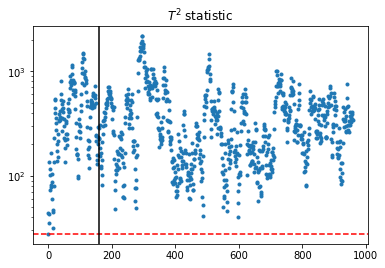

T2: 1.0


In [52]:
IDV = 15
df_test = test_faulty[(test_faulty.faultNumber==IDV) & 
                               (test_faulty.simulationRun==1)].iloc[:,3:]
kpca.test(apply_lag(df_test, lag=lag))
kpca.plotTestResult()

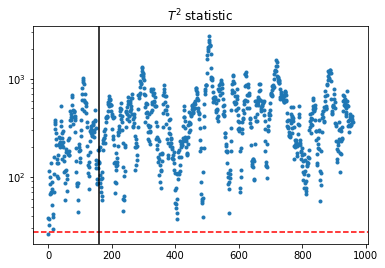

T2: 0.9989572471324296


In [53]:
IDV = 16
df_test = test_faulty[(test_faulty.faultNumber==IDV) & 
                               (test_faulty.simulationRun==1)].iloc[:,3:]
kpca.test(apply_lag(df_test, lag=lag))
kpca.plotTestResult()

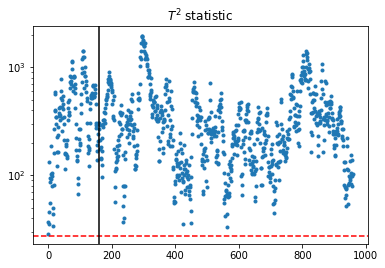

T2: 1.0


In [54]:
IDV = 17
df_test = test_faulty[(test_faulty.faultNumber==IDV) & 
                               (test_faulty.simulationRun==1)].iloc[:,3:]
kpca.test(apply_lag(df_test, lag=lag))
kpca.plotTestResult()

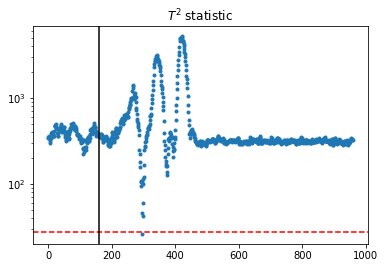

T2: 0.9989572471324296


In [55]:
IDV = 18
df_test = test_faulty[(test_faulty.faultNumber==IDV) & 
                               (test_faulty.simulationRun==1)].iloc[:,3:]
kpca.test(apply_lag(df_test, lag=lag))
kpca.plotTestResult()

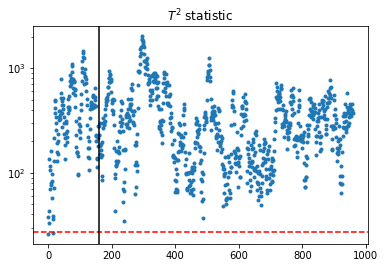

T2: 0.9979144942648592


In [56]:
IDV = 19
df_test = test_faulty[(test_faulty.faultNumber==IDV) & 
                               (test_faulty.simulationRun==1)].iloc[:,3:]
kpca.test(apply_lag(df_test, lag=lag))
kpca.plotTestResult()

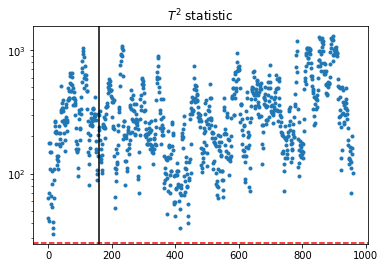

T2: 1.0


In [57]:
IDV = 20
df_test = test_faulty[(test_faulty.faultNumber==IDV) & 
                               (test_faulty.simulationRun==1)].iloc[:,3:]
kpca.test(apply_lag(df_test, lag=lag))
kpca.plotTestResult()